# Import Libraries and Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas_profiling
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
pd.set_option('display.max_columns', 500)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from matplotlib import rc
from collections import Counter

# Gather Data

In [3]:
df_students = pd.read_csv('student/students.csv')

In [4]:
df_students.drop('Unnamed: 0', axis=1, inplace= True)

In [5]:
df_students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,math


# Clean Data

In [6]:
df_students['failed'] = df_students['G3'] <= 10
df_students['failed'] = df_students['failed'].astype(int)
df_students.failed.value_counts()

0    661
1    383
Name: failed, dtype: int64

In [7]:
data_random_forest = df_students.copy()
df_students = pd.get_dummies(df_students, columns=['Medu','Fedu','Pstatus','school', 'sex', 'address', 'famsize', 'Mjob', 'Fjob', 'subject', 'reason', 'guardian'])

In [8]:
df_students.replace({'no':0, 'yes': 1}, inplace=True)

In [9]:
df_students.head()

,age,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,failed,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,Pstatus_A,Pstatus_T,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,subject_math,subject_portuguese,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,18,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0
1,17,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
2,15,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,15,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
4,16,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0


In [302]:
data_random_forest

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject,failed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,math,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,math,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,math,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,math,0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,math,1
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,1,2,5,10,15,15,15,math,0
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,12,12,11,math,0
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,6,6,5,6,math,1
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18,19,math,0
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,14,15,15,math,0


In [16]:

pandas_profiling.ProfileReport(df_students)

Number of variables,62
Number of observations,1044
Total Missing (%),0.0%
Total size in memory,227.4 KiB
Average record size in memory,223.1 B
Numeric,13
Categorical,0
Boolean,48
Date,0
Text (Unique),0
Rejected,1


# EDA

In [10]:
len(data_random_forest)
len(data_random_forest[data_random_forest['failed'] == 0])

661

In [11]:
data_random_forest.Fjob.value_counts()

other       584
services    292
teacher      65
at_home      62
health       41
Name: Fjob, dtype: int64

In [92]:
def plot_percent_bar(df, column, show_numbers = 'no'):
    # group Dataframe by preferred column
    groups = list(df.groupby(column))
    # create list for x_axis
    r = []
#     create list for green bar
    green = []
#     loop through groups and append data to green bar and r
    for i in range(0,len(groups)):
        passed =  len(groups[i][1][groups[i][1]['failed'] == 0])
        r_ready = groups[i][1].reset_index()
        length = len(groups[i][1])
        if show_numbers == 'no':
            r.append(str(r_ready.loc[0, column]))
        elif show_numbers == 'yes':
            r.append(str(r_ready.loc[0, column]) + ': ' + str(length))
        else:
            return 'Error: Show numbers must be assigned to yes or no'

        green.append(passed/length*100)
        
    red = [100-i for i in green]
    plt.bar(r, green,
        color='teal',
        edgecolor='white',
        width = 0.85
           )
    plt.bar(r, red,
        color='coral',
        bottom=green,
        edgecolor='white',
        width = 0.85,
        )
    plt.ylabel(column.capitalize())

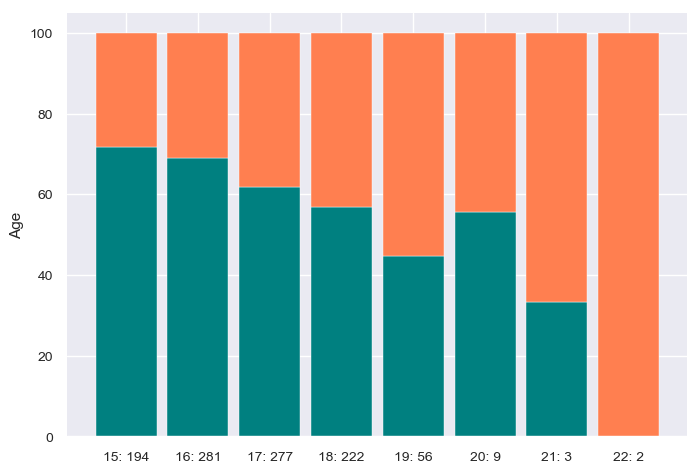

In [94]:
sns.set_style('darkgrid')
plot_percent_bar(data_random_forest, 'age', 'yes')

In [97]:
data_random_forest[data_random_forest['age'] > 19]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject,failed
247,GP,M,22,U,GT3,T,3,1,services,services,other,mother,1,1,3,no,no,no,no,no,no,yes,yes,5,4,5,5,5,1,16,6,8,8,math,1
306,GP,M,20,U,GT3,A,3,2,services,other,course,other,1,1,0,no,no,no,yes,yes,yes,no,no,5,5,3,1,1,5,0,17,18,18,math,0
376,MS,F,20,U,GT3,T,4,2,health,other,course,other,2,3,2,no,yes,yes,no,no,yes,yes,yes,5,4,3,1,1,3,4,15,14,15,math,0
390,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9,math,1
392,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7,math,1
674,GP,M,22,U,GT3,T,3,1,services,services,other,mother,1,1,3,no,no,no,no,no,no,yes,yes,5,4,5,5,5,1,12,7,8,5,portuguese,1
694,GP,F,20,R,GT3,T,2,1,other,other,course,other,2,2,0,no,yes,yes,yes,yes,no,yes,yes,1,2,3,1,2,2,8,10,12,12,portuguese,0
746,GP,M,20,U,GT3,A,3,2,services,other,course,other,1,1,2,no,no,no,yes,yes,yes,no,no,5,5,3,1,1,5,0,14,15,15,portuguese,0
802,GP,F,21,U,LE3,T,4,4,other,other,reputation,other,1,3,2,no,no,yes,yes,yes,yes,yes,no,3,3,2,1,1,5,0,9,12,12,portuguese,0
808,GP,M,21,R,LE3,T,1,1,at_home,other,course,other,2,2,2,no,yes,no,yes,yes,no,yes,yes,5,3,3,5,2,4,21,9,10,10,portuguese,1


In [96]:
data_random_forest.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,failed
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954,0.366858
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796,0.482178
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000,0.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000,1.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000,1.000000


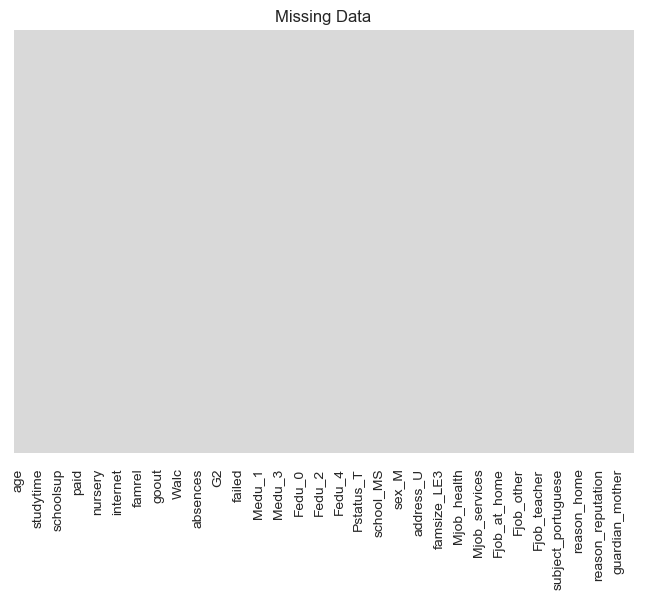

In [69]:
sns.heatmap(df_students.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'subject', 'failed']


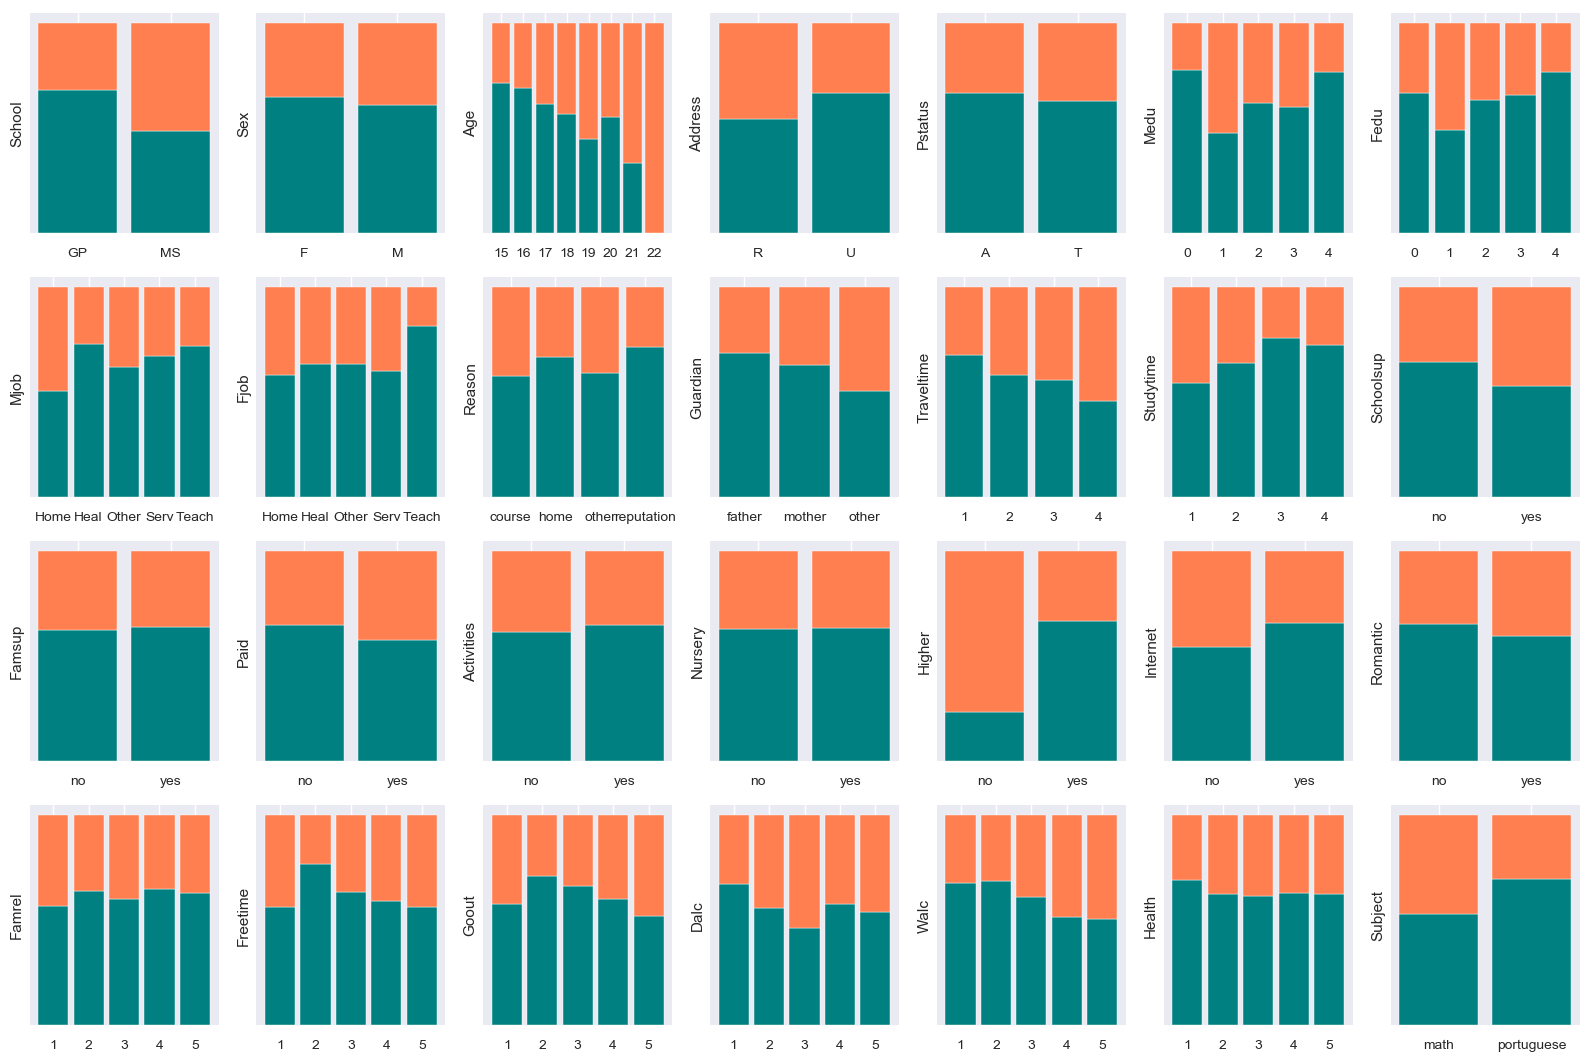

In [86]:
data_cols = list(data_random_forest.columns)
remove = (['G1', 'G2', 'G3', 'failed', 'absences', 'famsize', 'failures',])
data_cols = [x for x in data_cols if x not in remove]
plt.figure(figsize = (20,20))
for i, col in enumerate(data_cols):
    plt.subplot(6,7,i+1)
    plot_percent_bar(data_random_forest,col)
    plt.yticks([])

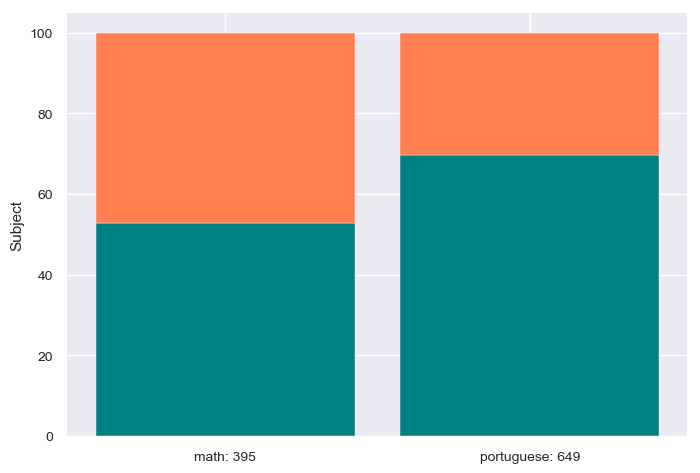

In [102]:
plot_percent_bar(data_random_forest, 'subject', 'yes')

In [19]:
df_students.failures.value_counts()

0    861
1    120
2     33
3     30
Name: failures, dtype: int64

In [20]:
df_students.head()

,age,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,failed,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,Pstatus_A,Pstatus_T,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,subject_math,subject_portuguese,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,18,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0
1,17,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
2,15,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,15,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
4,16,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0


In [109]:
def bar_plot_percent(df, column, target, argument):
    # group Dataframe by preferred column
    groups = list(df.groupby(column))
    # create list for x_axis
    r = []
#     create list for green bar
    green = []
#     loop through groups and append data to green bar and r
    for i in range(0,len(groups)):
        passed =  len(groups[i][1][groups[i][1][target] == argument])
        r_ready = groups[i][1].reset_index()
        df = len(groups[i][1])
        if column != 'Mjob' or column != 'Fjob':
            r.append(str(r_ready.loc[0, column])+':'  + str(df))
        elif column == 'Mjob' or column == 'Fjob':
            r = ['home', 'heal', 'other', 'serv', 'teach']
        green.append(passed/df*100)
    red = [100-i for i in green]
    plt.bar(r, green,
        color='teal',
        edgecolor='white',
        width = 0.85
           )
    plt.bar(r, red,
        color='coral',
        bottom=green,
        edgecolor='white',
        width = 0.85,
        )
    plt.ylabel(column.capitalize())

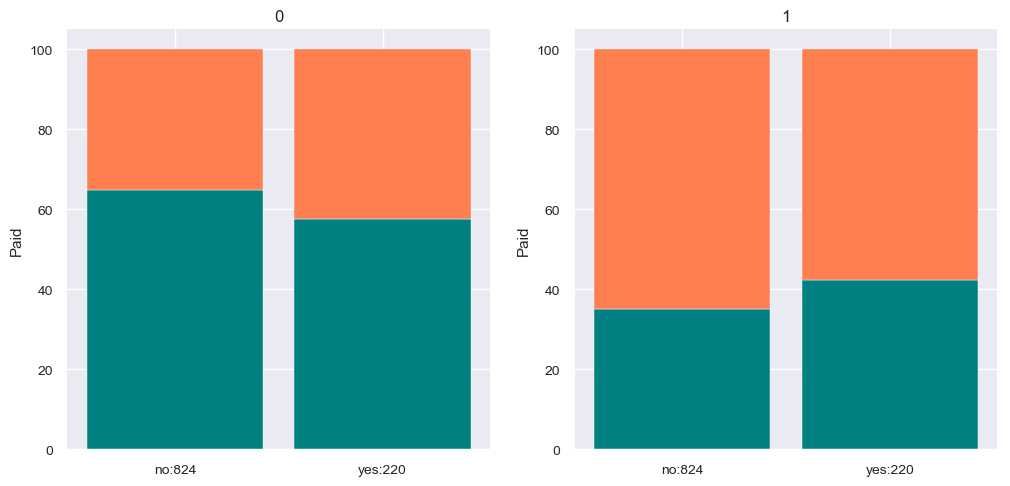

In [110]:
plt.figure(figsize=(12,12))
for i in range(0,2):
    plt.subplot(2,2,i+1)
    bar_plot_percent(data_random_forest, 'paid','failed', i)
    plt.title(i)

In [23]:
df_students['school-travel'] = (df_students['school_GP'] + 4) * (df_students['traveltime'])
df_students['school-travel'].value_counts()

5     526
10    193
8     127
4      97
12     42
15     35
20     18
16      6
Name: school-travel, dtype: int64

In [19]:
cols = list(data_random_forest.columns)
cols

['school',
 'sex',
 'age',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2',
 'G3',
 'subject',
 'failed']

ValueError: num must be 1 <= num <= 32, not 33

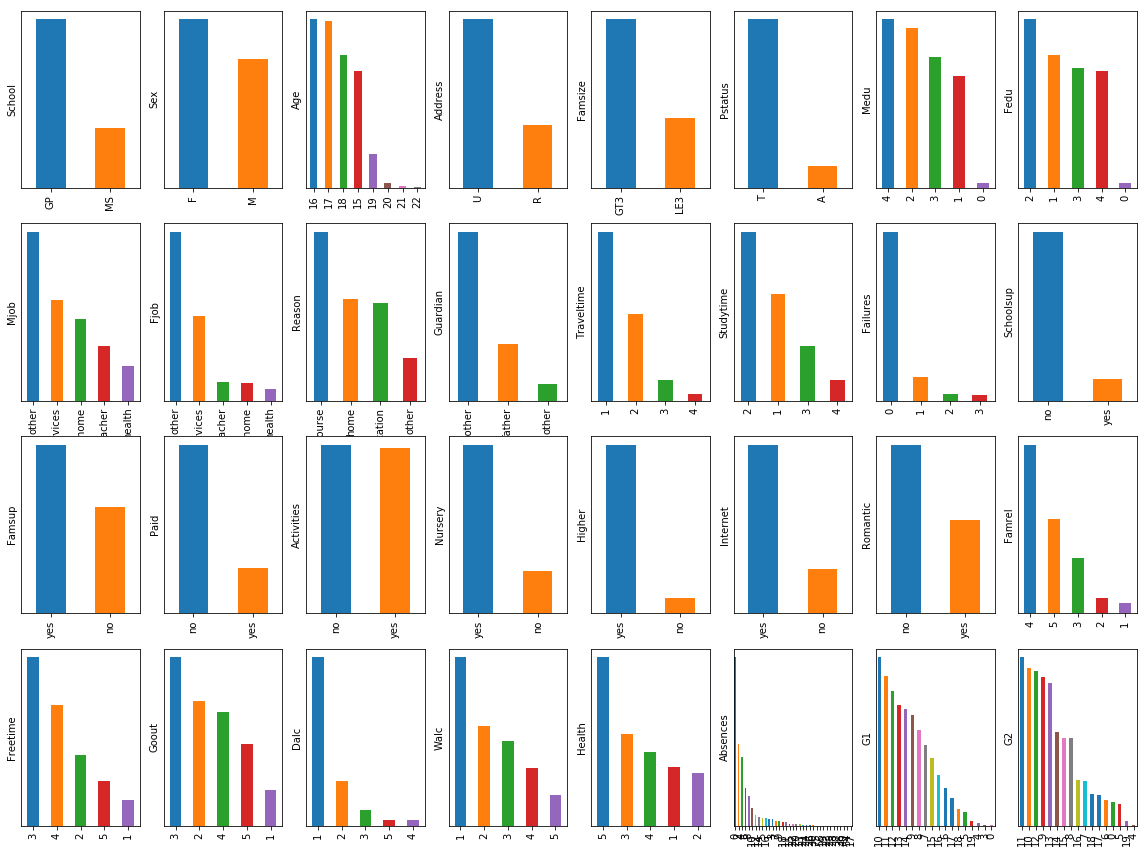

In [29]:

plt.figure(figsize = (20,15))
for i, col in enumerate(cols):
    plt.subplot(4,8,i+1)
    data_random_forest[col].value_counts().plot(kind='bar')
    plt.ylabel(col.capitalize())
    plt.yticks([])

In [25]:
df_students.address_R.value_counts()

0    759
1    285
Name: address_R, dtype: int64

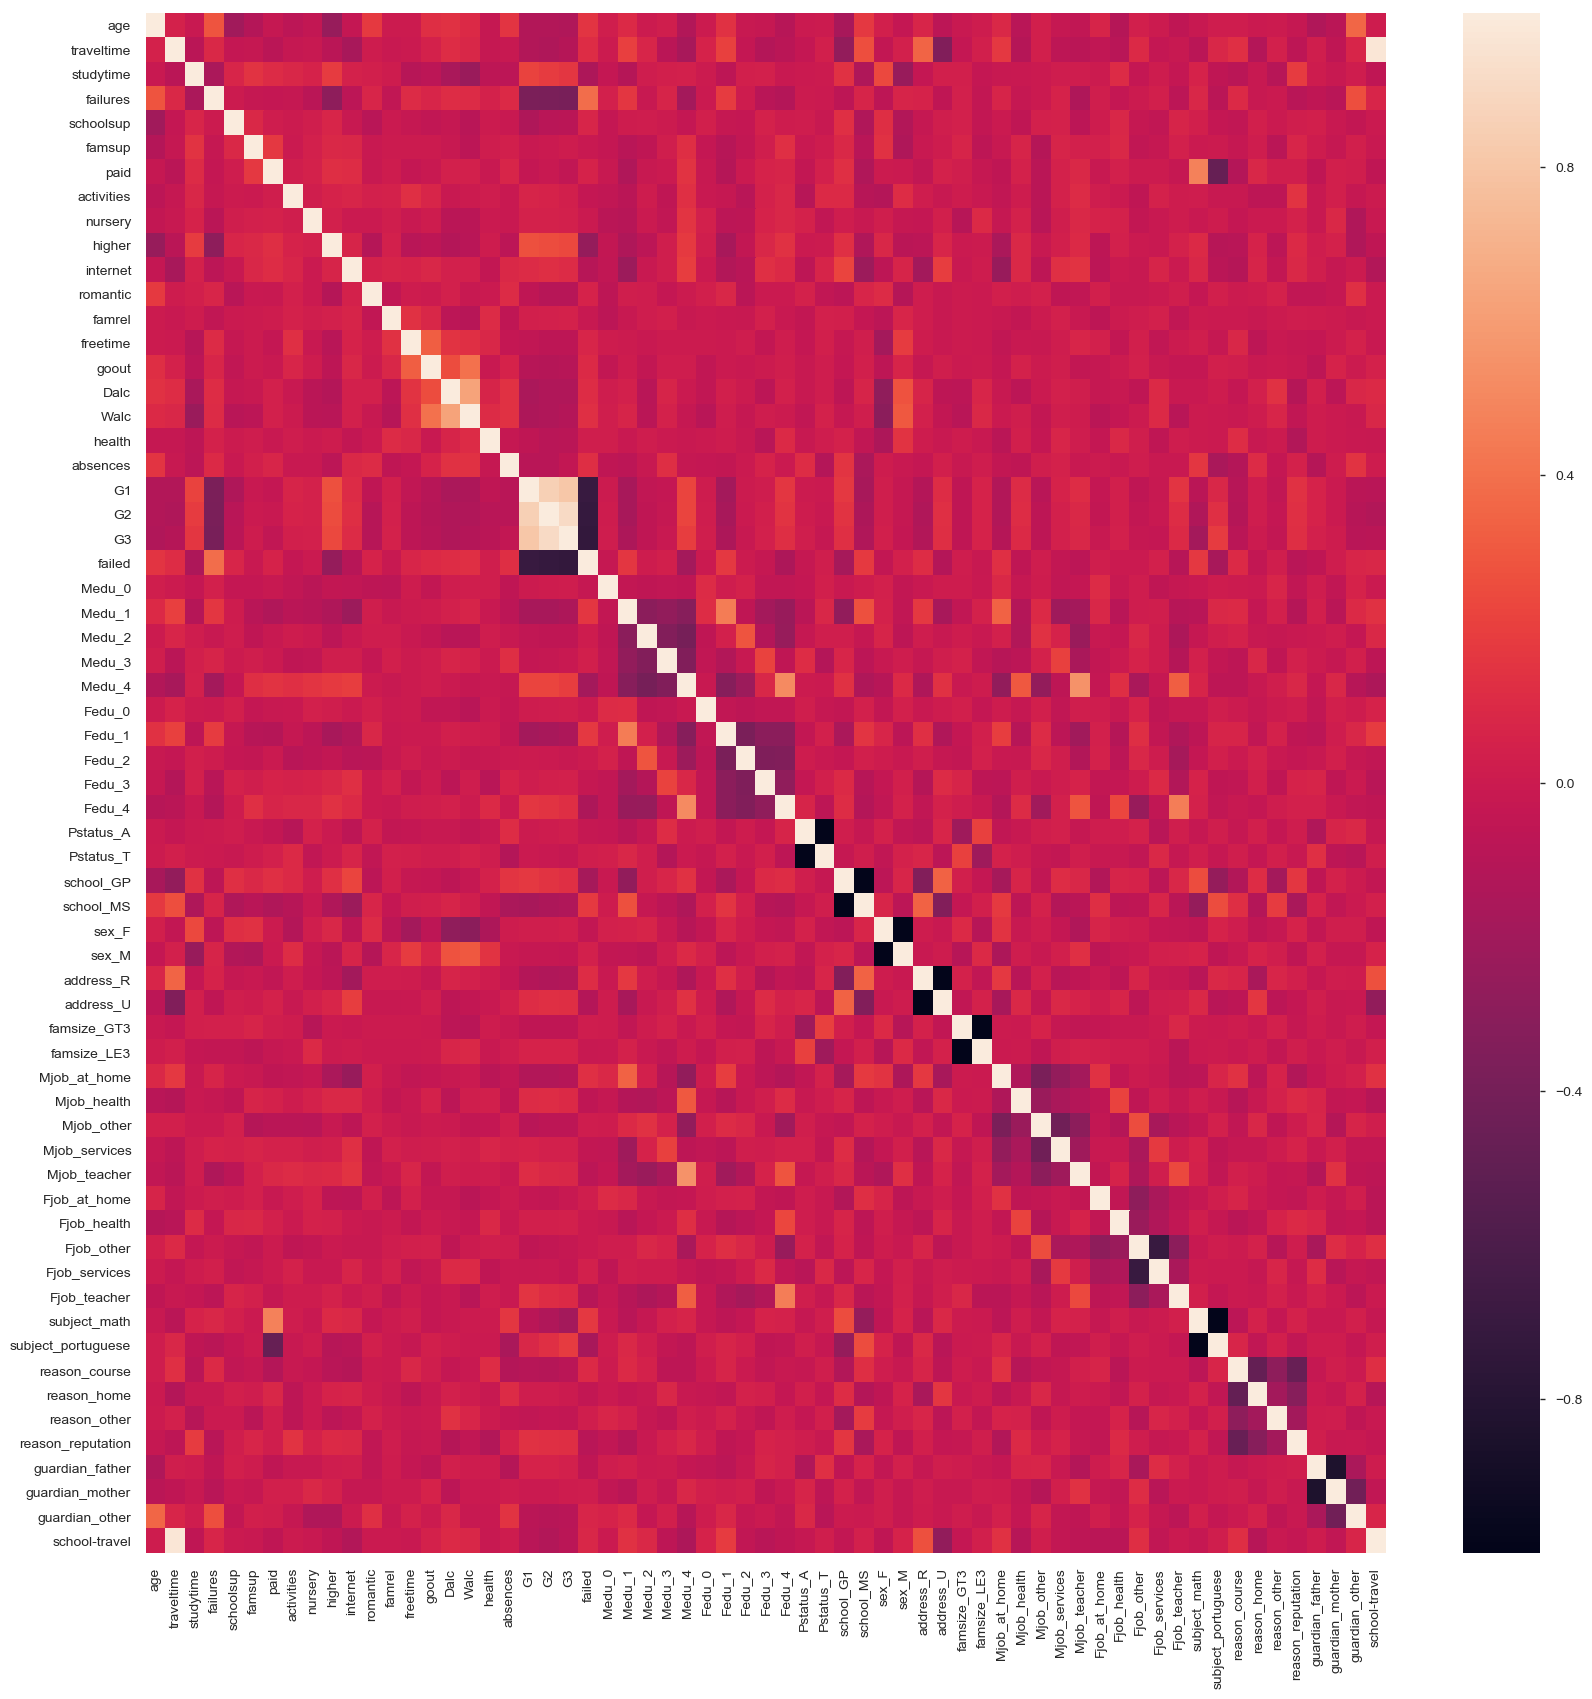

In [26]:
plt.figure(figsize = (20,20))
sns.heatmap(df_students.corr())

# Scale and preform train test split

In [115]:
poly = PolynomialFeatures(interaction_only=False, include_bias=False)
poly.fit(df_students.drop(['failed', 'G1', 'G2', 'G3'], axis=1))
column_names = poly.get_feature_names(df_students.drop(['failed', 'G1', 'G2', 'G3'], axis=1).columns)
df_poly= pd.DataFrame(poly.transform(df_students.drop(['failed', 'G1', 'G2', 'G3'], axis=1)), columns=column_names)

In [116]:
mm = MinMaxScaler()

In [117]:
columns = df_students.columns
poly_columns = df_poly.columns

In [118]:
df_students[columns] = mm.fit_transform(df_students[columns])
df_poly[poly_columns] = mm.fit_transform(df_poly[poly_columns])

,age,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,Pstatus_A,Pstatus_T,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,subject_math,subject_portuguese,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school-travel,age^2,age traveltime,age studytime,age failures,age schoolsup,age famsup,age paid,age activities,age nursery,age higher,age internet,age romantic,age famrel,age freetime,age goout,age Dalc,age Walc,age health,age absences,age Medu_0,age Medu_1,age Medu_2,age Medu_3,age Medu_4,age Fedu_0,age Fedu_1,age Fedu_2,age Fedu_3,age Fedu_4,age Pstatus_A,age Pstatus_T,age school_GP,age school_MS,age sex_F,age sex_M,age address_R,age address_U,age famsize_GT3,age famsize_LE3,age Mjob_at_home,age Mjob_health,age Mjob_other,age Mjob_services,age Mjob_teacher,age Fjob_at_home,age Fjob_health,age Fjob_other,age Fjob_services,age Fjob_teacher,age subject_math,age subject_portuguese,age reason_course,age reason_home,age reason_other,age reason_reputation,age guardian_father,age guardian_mother,age guardian_other,age school-travel,traveltime^2,traveltime studytime,traveltime failures,traveltime schoolsup,traveltime famsup,traveltime paid,traveltime activities,traveltime nursery,traveltime higher,traveltime internet,traveltime romantic,traveltime famrel,traveltime freetime,traveltime goout,traveltime Dalc,traveltime Walc,traveltime health,traveltime absences,traveltime Medu_0,traveltime Medu_1,traveltime Medu_2,traveltime Medu_3,traveltime Medu_4,traveltime Fedu_0,traveltime Fedu_1,traveltime Fedu_2,traveltime Fedu_3,traveltime Fedu_4,traveltime Pstatus_A,traveltime Pstatus_T,traveltime school_GP,traveltime school_MS,traveltime sex_F,traveltime sex_M,traveltime address_R,traveltime address_U,traveltime famsize_GT3,traveltime famsize_LE3,traveltime Mjob_at_home,traveltime Mjob_health,traveltime Mjob_other,traveltime Mjob_services,traveltime Mjob_teacher,traveltime Fjob_at_home,traveltime Fjob_health,traveltime Fjob_other,traveltime Fjob_services,traveltime Fjob_teacher,traveltime subject_math,traveltime subject_portuguese,traveltime reason_course,traveltime reason_home,traveltime reason_other,traveltime reason_reputation,traveltime guardian_father,traveltime guardian_mother,traveltime guardian_other,traveltime school-travel,studytime^2,studytime failures,studytime schoolsup,studytime famsup,studytime paid,studytime activities,studytime nursery,studytime higher,studytime internet,studytime romantic,studytime famrel,studytime freetime,studytime goout,studytime Dalc,studytime Walc,studytime health,studytime absences,studytime Medu_0,studytime Medu_1,studytime Medu_2,studytime Medu_3,studytime Medu_4,studytime Fedu_0,studytime Fedu_1,studytime Fedu_2,studytime Fedu_3,studytime Fedu_4,studytime Pstatus_A,studytime Pstatus_T,studytime school_GP,studytime school_MS,studytime sex_F,studytime sex_M,studytime address_R,studytime address_U,studytime famsize_GT3,studytime famsize_LE3,studytime Mjob_at_home,studytime Mjob_health,studytime Mjob_other,studytime Mjob_services,studytime Mjob_teacher,studytime Fjob_at_home,studytime Fjob_health,studytime Fjob_other,studytime Fjob_services,studytime Fjob_teacher,studytime subject_math,studytime subject_portuguese,studytime reason_course,studytime reason_home,studytime reason_other,studytime reason_reputation,studytime guardian_father,studytime guardian_mother,studytime guardian_other,studytime school-travel,failures^2,failures schoolsup,failures famsup,failures paid,failures activities,failures nursery,failures higher,failures internet,failures romantic,failures famrel,failures freetime,failures goout,failures Dalc,failures Walc,failure

In [147]:
features = ['age', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'Pstatus_T', 'school_GP', 'G1', 'G2',
        'sex_F', 'address_R', 'Medu_0', 'Medu_1', 'Medu_2', 'Medu_3',
        'Fedu_0', 'Fedu_1', 'Fedu_2', 'Fedu_3',#'school-travel',
       'famsize_LE3', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Fjob_at_home', 'Fjob_health',
       'Fjob_other', 'Fjob_services',  'subject_math',
        'reason_course', 'reason_home', 'reason_other',
        'guardian_father', 'guardian_mother']

In [148]:
X = df_students[features]
y = df_students['failed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [121]:
# coefs = list(zip(X.columns, lr.coef_))
len(X_train)/len(X_test) 

3.9952153110047846

In [171]:
# for col, coef in zip(X.columns, lr.coef_[0]):
#     print(col.upper()+': '+ str(coef))

# Sampling

In [189]:
training  = pd.concat([X_train, y_train], axis=1)
passed = training[training.failed==0]
failed = training[training.failed==1]

In [190]:
len(passed) > len(failed)

True

In [150]:
def sampling(x, y, how, attributes = features, target = 'failed'):
    
    training  = pd.concat([x, y], axis=1)
    passed = training[training[target]==0]
    failed = training[training[target]==1]
    print(len(failed))
    print(len(passed))
    smaller = passed if len(passed) < len(failed) else failed
    bigger = passed if len(passed) > len(failed) else failed
    if how == 'up':
        upsample = resample(smaller,
                          replace=True, # sample with replacement
                          n_samples=len(bigger))
        upsampled = pd.concat([bigger, upsample])
        X_train = upsampled[attributes]
        y_train = upsampled[target]
        
        return X_train, y_train
        
        
    elif how == 'down':
        downsample = resample(bigger,
                                replace = False, # sample without replacement
                                n_samples = len(smaller))
        downsampled = pd.concat([smaller, downsample])
        X_train = downsampled[attributes]
        y_train = downsampled[target]
        
        return X_train, y_train
        
    else:
        return 'Error: Invalid Sampling Method'

In [151]:
down_x, down_y = sampling(X_train, y_train, 'down')
down_y.value_counts()

302
533


0.0    302
1.0    302
Name: failed, dtype: int64

# Logistic Regression

In [152]:
def model_enact(model_name, X_train, y_train, X_test, y_test, sample = None, attributes = features):
    if sample == 'up' or sample == 'down':
        X_fit, y_fit = sampling(X_train, y_train, sample, attributes)
    else:
        X_fit, y_fit = X_train, y_train
        
    model = model_name
    model.fit(X_fit, y_fit)
    p_train = model.predict(X_train)
    p_test = model.predict(X_test)
    print('Train Accuracy score: ', accuracy_score(y_train, p_train),'\n')
    print('Train F1 score: ', f1_score(y_train, p_train),'\n')
    print(classification_report(y_train, p_train), '\n\n\n\n')
    
    print('Test Accuracy score: ', accuracy_score(y_test, p_test), '\n')
    print('Test F1 score: ', f1_score(y_test, p_test), '\n')
    print(classification_report(y_test, p_test), '\n\n\n\n')
    print(confusion_matrix(y_test, p_test))
    
    return confusion_matrix(y_test, p_test)

In [153]:
logistic = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = [0.0001, 0.02, 0.1, 0.5, 1, 2, 5, 10]
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

lr_gs = GridSearchCV(logistic, hyperparameters, cv = 5 , scoring='f1', n_jobs=-1) 

In [154]:
lr_plot = model_enact(lr_gs, X_train, y_train, X_test, y_test, 'up', )

302
533
Train Accuracy score:  0.9269461077844311 

Train F1 score:  0.901453957996769 

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       533
         1.0       0.88      0.92      0.90       302

   micro avg       0.93      0.93      0.93       835
   macro avg       0.92      0.93      0.92       835
weighted avg       0.93      0.93      0.93       835
 




Test Accuracy score:  0.9043062200956937 

Test F1 score:  0.8795180722891566 

              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92       128
         1.0       0.86      0.90      0.88        81

   micro avg       0.90      0.90      0.90       209
   macro avg       0.90      0.90      0.90       209
weighted avg       0.91      0.90      0.90       209
 




[[116  12]
 [  8  73]]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [293]:
polt_split_df = pd.concat([df_poly, df_students['failed']], axis=1)
poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(
    polt_split_df.drop('failed', axis=1), polt_split_df['failed'], test_size=0.2)

In [301]:
poly_lr_gs = GridSearchCV(logistic, hyperparameters, cv = 5 , scoring='f1', n_jobs=-1)
poly_lr_plot = model_enact(poly_lr_gs, poly_X_train, poly_X_test,
                           poly_y_train, poly_y_test, 'up', )

KeyError: 'failed'

In [145]:
final = []

In [146]:
cos = list(lr_gs.best_estimator_.coef_)[0]
columns = X_train.columns

for coef, col in zip(cos, columns):
    if abs(coef) > 0.01:
        final.append(col)
final

['failures',
 'nursery',
 'higher',
 'famrel',
 'Pstatus_T',
 'age G3',
 'traveltime nursery',
 'failures nursery',
 'schoolsup activities',
 'schoolsup romantic',
 'schoolsup Pstatus_A',
 'schoolsup Pstatus_T',
 'schoolsup famsize_GT3',
 'schoolsup subject_math',
 'schoolsup subject_portuguese',
 'schoolsup guardian_mother',
 'famsup higher',
 'famsup romantic',
 'famsup G3',
 'famsup Fedu_4',
 'famsup Pstatus_A',
 'famsup sex_F',
 'famsup Fjob_services',
 'famsup subject_portuguese',
 'famsup reason_reputation',
 'paid nursery',
 'paid Mjob_at_home',
 'activities internet',
 'activities romantic',
 'activities health',
 'activities Pstatus_T',
 'activities address_U',
 'activities Mjob_at_home',
 'activities Mjob_services',
 'activities Fjob_at_home',
 'activities reason_reputation',
 'nursery famrel',
 'nursery G3',
 'nursery Medu_3',
 'nursery famsize_LE3',
 'nursery Mjob_services',
 'nursery Fjob_health',
 'nursery subject_math',
 'nursery reason_reputation',
 'higher freetime',
 

In [101]:
co_lr = list(lr_gs.best_estimator_.coef_)[0]
columns = X_train.columns
final = {}
for coef, col in zip(co_lr, columns):
    final[col] = coef
final

{'age': -0.18075672807368579,
 'traveltime': 0.06537534144328967,
 'studytime': -0.6489448956759125,
 'failures': 5.45588586956443,
 'schoolsup': 1.5124478687036853,
 'famsup': 0.0570266972712667,
 'paid': 0.15373671165266378,
 'higher': -1.6355916888152395,
 'internet': 0.16422823572403272,
 'romantic': -0.27326727491801905,
 'famrel': 0.41328342444980265,
 'freetime': -0.21229278695734252,
 'goout': 0.0,
 'Dalc': 0.029751085981182878,
 'Walc': 0.5766381834717227,
 'health': 0.31847042963765526,
 'absences': 2.1164575927887816,
 'Pstatus_T': 0.0759469535713993,
 'school_GP': -1.2838826570885116,
 'sex_F': -0.11621863282414806,
 'address_R': 0.236893037512708,
 'Medu_0': -0.6713995427283648,
 'Medu_1': -0.018610072544561804,
 'Medu_2': 0.48115331401639494,
 'Medu_3': 0.5047191974535759,
 'Fedu_0': 0.006276483403000512,
 'Fedu_1': 0.9558333810198656,
 'Fedu_2': 0.3365067502131459,
 'Fedu_3': 0.4872583477257486,
 'famsize_LE3': 0.1010628254576965,
 'Mjob_at_home': 0.25550821219198394,
 '

In [126]:
model_enact(KNeighborsClassifier() , X_train, y_train, X_test, y_test, 'up')

302
533
Train Accuracy score:  0.7628742514970059 

Train F1 score:  0.691588785046729 

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       533
         1.0       0.65      0.74      0.69       302

   micro avg       0.76      0.76      0.76       835
   macro avg       0.75      0.76      0.75       835
weighted avg       0.77      0.76      0.77       835
 




Test Accuracy score:  0.6172248803827751 

Test F1 score:  0.48051948051948046 

              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70       128
         1.0       0.51      0.46      0.48        81

   micro avg       0.62      0.62      0.62       209
   macro avg       0.59      0.59      0.59       209
weighted avg       0.61      0.62      0.61       209
 




[[92 36]
 [44 37]]


array([[92, 36],
       [44, 37]])

In [41]:
lr_ups = LogisticRegression()
lr_ups.fit(up_X_train, up_y_train)
pred_train_up = lr_ups.predict(up_X_train)
pred_test_up = lr_ups.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# KNN

In [247]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(up_X_train, up_y_train)

NameError: name 'up_X_train' is not defined

In [83]:
knn_ptrain = knn.predict(X_train)
knn_ptest = knn.predict(X_test)

In [1]:
print('Train Accuracy score: ', accuracy_score(y_train, knn_ptrain))
print('Train F1 score: ', f1_score(y_train, knn_ptrain))

print('Test Accuracy score: ', accuracy_score(y_test, knn_ptest))
print('Test F1 score: ', f1_score(y_test, knn_ptest))

print(classification_report(y_train, knn_ptrain))
print(classification_report(y_test, knn_ptest))

NameError: name 'accuracy_score' is not defined

In [245]:
print(classification_report(y_train, knn_ptrain))
print(classification_report(y_test, knn_ptest))

NameError: name 'knn_ptrain' is not defined

# Random Forest

In [127]:
model_enact(RandomForestClassifier(n_estimators=100, max_depth=8), 
      X_train, y_train, X_test, y_test)

Train Accuracy score:  0.8874251497005988 

Train F1 score:  0.8164062500000001 

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       533
         1.0       1.00      0.69      0.82       302

   micro avg       0.89      0.89      0.89       835
   macro avg       0.92      0.85      0.87       835
weighted avg       0.90      0.89      0.88       835
 




Test Accuracy score:  0.6889952153110048 

Test F1 score:  0.4881889763779527 

              precision    recall  f1-score   support

         0.0       0.69      0.88      0.78       128
         1.0       0.67      0.38      0.49        81

   micro avg       0.69      0.69      0.69       209
   macro avg       0.68      0.63      0.63       209
weighted avg       0.69      0.69      0.66       209
 




[[113  15]
 [ 50  31]]


array([[113,  15],
       [ 50,  31]])

In [87]:
rfc = RandomForestClassifier(max_depth = 7,
 max_features = 0.5,
 min_samples_leaf = 0.03
 , n_estimators = 50)
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,n_jobs=-1)

In [88]:
rfc.fit(up_X_train, up_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.03, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
rfc_ptrain = rfc.predict(X_train)
rfc_ptest = rfc.predict(X_test)

In [90]:
print('Train Accuracy score: ', accuracy_score(y_train, rfc_ptrain))
print('Train F1 score: ', f1_score(y_train, rfc_ptrain))

print('Test Accuracy score: ', accuracy_score(y_test, rfc_ptest))
print('Test F1 score: ', f1_score(y_test, rfc_ptest))

print(classification_report(y_train, rfc_ptrain))
print(classification_report(y_test, rfc_ptest))

Train Accuracy score:  0.7868263473053893
Train F1 score:  0.7003367003367004
Test Accuracy score:  0.7511961722488039
Test F1 score:  0.7011494252873564
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83       539
         1.0       0.70      0.70      0.70       296

   micro avg       0.79      0.79      0.79       835
   macro avg       0.77      0.77      0.77       835
weighted avg       0.79      0.79      0.79       835

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       122
         1.0       0.70      0.70      0.70        87

   micro avg       0.75      0.75      0.75       209
   macro avg       0.74      0.74      0.74       209
weighted avg       0.75      0.75      0.75       209



# Grid Search Random Forest

In [128]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(
    data_random_forest.drop(['failed','G1','G2', 'G2'], axis=1), 
    data_random_forest.failed, test_size=0.2)

In [92]:
rf_X_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,subject
744,GP,F,17,U,GT3,T,3,2,health,health,reputation,father,1,4,0,no,yes,no,yes,no,yes,yes,no,5,2,2,1,2,5,0,18,portuguese
675,GP,M,18,R,LE3,T,3,3,other,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,yes,4,3,3,1,3,5,8,10,portuguese
20,GP,M,15,U,GT3,T,4,3,teacher,other,reputation,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,1,1,1,1,0,15,math
899,MS,F,19,U,LE3,T,2,2,other,other,home,mother,1,3,0,no,no,no,no,yes,yes,yes,yes,5,4,5,1,1,1,0,13,portuguese
924,MS,F,16,U,LE3,T,4,4,services,services,other,father,2,1,0,no,yes,no,no,yes,yes,no,no,5,1,3,1,2,5,1,11,portuguese


In [129]:
param_grid = { 
    'n_estimators': list(range(50,500,15)),
    'max_features': [0.2, 0.25, 0.33, 0.5],
    'max_depth' : range(1,10,1),
    'min_samples_leaf': [0.03,0.04,0.05,0.06]
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,n_jobs=-1)
CV_rfc.fit(X_train, y_train)

NameError: name 'rfc' is not defined

In [ ]:
cv_rfc_ptrain = CV_rfc.best_estimator_.predict(X_train)
cv_rfc_ptest = CV_rfc.best_estimator_.predict(X_test)

In [ ]:
print('Train Accuracy score: ', accuracy_score(y_train, cv_rfc_ptrain))
print('Train F1 score: ', f1_score(y_train, cv_rfc_ptrain))

print('Test Accuracy score: ', accuracy_score(y_test, cv_rfc_ptest))
print('Test F1 score: ', f1_score(y_test, cv_rfc_ptest))

print(classification_report(y_train, cv_rfc_ptrain))
print(classification_report(y_test, cv_rfc_ptest))

In [ ]:
CV_rfc.best_params_

## Pickle CV Random Forest

In [66]:
cv_random_forest_pickle_path = 'cv_xgb.pkl'

In [67]:

rf_best = gsearch1.best_estimator_
# Create an variable to pickle and open it in write mode
model_pickle = open(cv_random_forest_pickle_path, 'wb')
pickle.dump(rf_best, model_pickle)
model_pickle.close()

In [68]:
rf_model_pkl = open(cv_random_forest_pickle_path, 'rb')
rf_model = pickle.load(rf_model_pkl)
print("Loaded XGboost model :: ", rf_model)
rf_model_pkl.close()

Loaded XGboost model ::  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=nan, n_estimators=50,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


# XG boost

In [136]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 10, n_estimators = 100, n_jobs=-1)

In [137]:
model_enact(xg_clf, X_train, y_train, X_test, y_test, 'down')

302
533
Train Accuracy score:  0.7856287425149701 

Train F1 score:  0.7089430894308943 

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       533
         1.0       0.70      0.72      0.71       302

   micro avg       0.79      0.79      0.79       835
   macro avg       0.77      0.77      0.77       835
weighted avg       0.79      0.79      0.79       835
 




Test Accuracy score:  0.6889952153110048 

Test F1 score:  0.5806451612903225 

              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       128
         1.0       0.61      0.56      0.58        81

   micro avg       0.69      0.69      0.69       209
   macro avg       0.67      0.66      0.67       209
weighted avg       0.68      0.69      0.69       209
 




[[99 29]
 [36 45]]


array([[99, 29],
       [36, 45]])

In [138]:
xg_clf.coef_

AttributeError: Coefficients are not defined for Booster type gbtree

In [44]:
xg_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [140]:
data_dmatrix = xgb.DMatrix(data = df_students[features], label = df_students['failed'])
xgb_params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 2, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=xgb_params, nfold=5,
                    num_boost_round=500,early_stopping_rounds=5,metrics="logloss",
                    as_pandas=True)
cv_results

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.684286,0.001069,0.686455,0.002011
1,0.674936,0.001662,0.678179,0.002840
2,0.661975,0.006880,0.665834,0.007307
3,0.652115,0.010276,0.656206,0.010981
4,0.640858,0.009070,0.646628,0.010752
5,0.634300,0.010361,0.640893,0.011417
6,0.628703,0.010925,0.636287,0.011903
7,0.619867,0.008668,0.627783,0.009386
8,0.615653,0.008927,0.623790,0.009539
9,0.610167,0.008448,0.618911,0.009233


In [141]:
param_test1 = {
 'max_depth':range(3,20,2),
 'min_child_weight':range(1,20,2),
 'n_estimators': range(50,500, 25),
 'max_depth': range(3,20,1),
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch1.fit(df_students[features],df_students['failed'])

In [143]:
xgb_plot = model_enact(gsearch1, X_train, y_train, X_test, y_test)

Train Accuracy score:  0.8419161676646707 

Train F1 score:  0.7555555555555555 

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88       533
         1.0       0.86      0.68      0.76       302

   micro avg       0.84      0.84      0.84       835
   macro avg       0.85      0.81      0.82       835
weighted avg       0.84      0.84      0.84       835
 




Test Accuracy score:  0.7033492822966507 

Test F1 score:  0.523076923076923 

              precision    recall  f1-score   support

         0.0       0.71      0.88      0.78       128
         1.0       0.69      0.42      0.52        81

   micro avg       0.70      0.70      0.70       209
   macro avg       0.70      0.65      0.65       209
weighted avg       0.70      0.70      0.68       209
 




[[113  15]
 [ 47  34]]


In [65]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=50,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [74]:
p_train = gsearch1.predict(X_train)
p_test = gsearch1.predict(X_test)
print('Train Accuracy score: ', accuracy_score(y_train, p_train),'\n')
print('Train F1 score: ', f1_score(y_train, p_train),'\n')
print(classification_report(y_test, p_test), '\n\n\n\n')


Train Accuracy score:  0.7976047904191617 

Train F1 score:  0.6558044806517311 

              precision    recall  f1-score   support

         0.0       0.72      0.86      0.78       122
         1.0       0.73      0.53      0.61        87

   micro avg       0.72      0.72      0.72       209
   macro avg       0.72      0.69      0.70       209
weighted avg       0.72      0.72      0.71       209
 






In [72]:
weight = ['right', 'wrong']

In [121]:
counternp.unique(guess, return_counts=True)

(array(['right', 'wrong'], dtype='<U5'), array([56, 44]))

In [138]:
(guess == 'right').sum()

56

In [166]:
guesses = []
for i in range(0,1000):
    guess = np.random.choice(weight, 100, p =[0.55, 0.45])
    guesses.append((guess == 'wrong').sum())

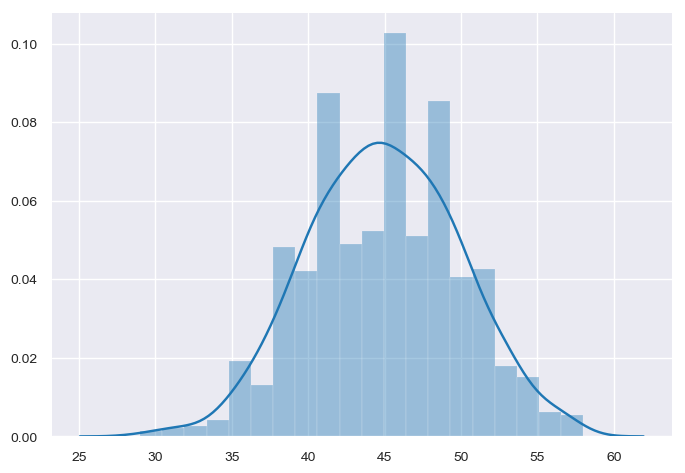

In [167]:
sns.distplot(guesses, bins = 20)

In [177]:
wrong = []
for i in guesses:
    if i >=4:
        wrong.append(i)
len(wrong)

310

In [133]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

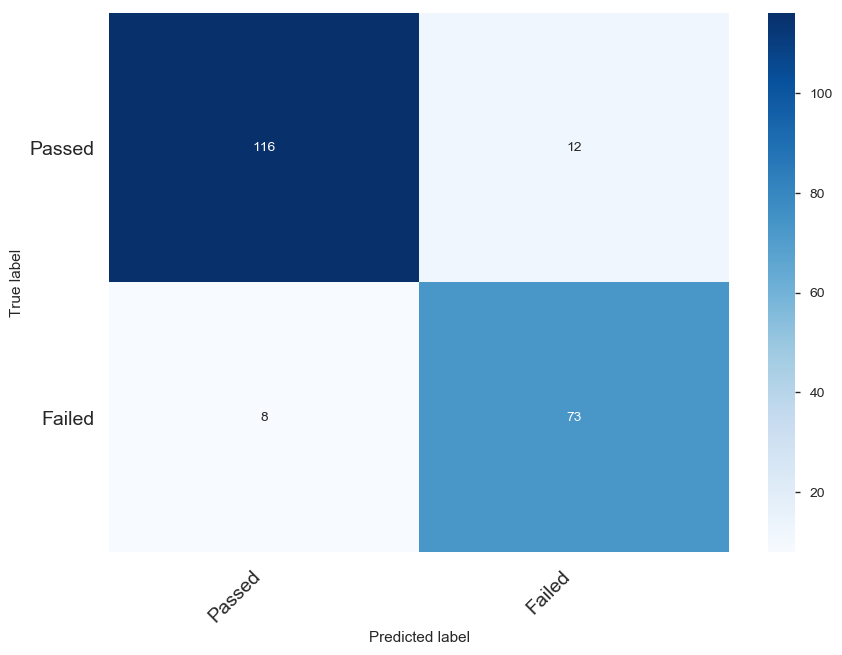

In [155]:
print_confusion_matrix(lr_plot, ['Passed', 'Failed'])

In [243]:
laces = ['a', 'b', 'c']
for i in laces:
    i = 10

10
10
10


In [ ]:
least = {'grp': }

In [317]:
def birthday(n):
    return 1- ((364/365)**((n*(n-1))/2))

In [305]:
365/25

14.6

In [306]:
100/14.6

6.8493150684931505

In [310]:
birthday(25)

0.5609077642340204

In [320]:
numbers = []
n = 80
for i in range(0,n):
    numbers.append(birthday(i))

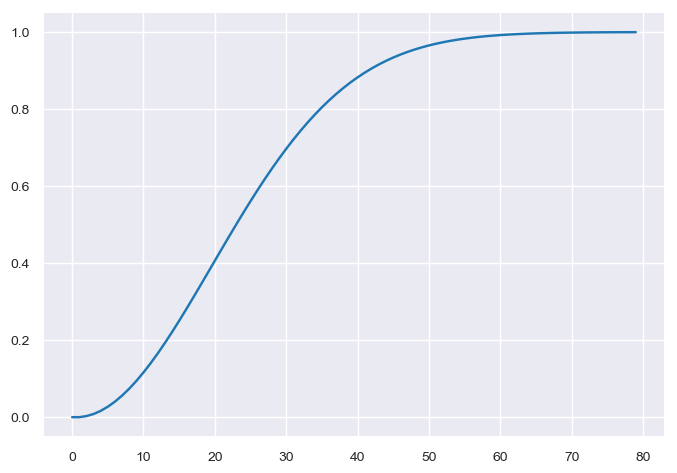

In [322]:
plt.plot(range(0,n), numbers)